In [43]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import lovely_tensors as lt
lt.monkey_patch()
from lovely_numpy import lo

%matplotlib inline
import matplotlib.pyplot as plt

""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2

import scipy
import json
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of mmpose.models.detectors.top_down_moe failed: Traceback (most recent call last):
  File "/datagrid/personal/baljibil/repos/env-vitpose/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/datagrid/personal/baljibil/repos/env-vitpose/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/datagrid/personal/baljibil/repos/env-vitpose/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 843, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/mnt/datagrid/personal/baljibil/repos/ViTPose/mmpose/models/detectors/top_down_moe.py", line 27, in <module>
    class TopDownMoE(BasePose):
  File "/mnt/datagrid/personal/baljibil/repos/

In [44]:
device = "cuda:1"

### Load the datasets

In [147]:
ROOT_FOLDER = "/datagrid/personal/baljibil"
# prediction
with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/resnet/IMG-coco_val-Rep-mpii.json') as f:
    annot_mpii_on_coco = json.load(f)
# with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_base_multi/IMG-coco_small-Rep-mpii1.json') as f:
#     annot_mpii_on_coco1 = json.load(f)
# with open(ROOT_FOLDER + '/repos/mapping-HPE-representations/data/vitpose_base_multihead/IMG-coco_small-Rep-coco.json') as f:
#     annot_coco_on_coco = json.load(f)
annot_mpii_on_coco = sorted(annot_mpii_on_coco, key=lambda x: int(x['image_id']))

In [148]:
from mmpose.datasets import build_dataloader, build_dataset
from mmcv import Config, DictAction

# cfg = Config.fromfile("/datagrid/personal/baljibil/repos/ViTPose/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/vitPose+_base_coco+aic+mpii+ap10k+apt36k+wholebody_256x192_udp.py")
cfg = Config.fromfile("/datagrid/personal/baljibil/repos/ViTPose/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/res50_coco_256x192.py")


coco_dataset = build_dataset(cfg.data.test, dict(test_mode=True))
annot_truth = coco_dataset.db
annot_truth = sorted(annot_truth, key=lambda x: int(x['image_file'][-16:][:-4]))

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
=> num_images: 5000
=> load 6352 samples


### Check if images are correctly aligned.

In [149]:

from collections import defaultdict 
kpts_gt = defaultdict(list)

for i in range(len(annot_truth)):
  kpts_gt[int(annot_truth[i]['image_file'][-10:][:-4])].append(annot_truth[i])
print(len(kpts_gt.items()))

kpts_mpii = defaultdict(list)

for i in range(len(annot_mpii_on_coco)):
  kpts_mpii[int(annot_mpii_on_coco[i]['image_id'])].append(annot_mpii_on_coco[i])

print(len(kpts_mpii.items()))

wrong = 0
non_matching_keys = []

for key, value in kpts_gt.items():
  if len(kpts_gt[key]) != len(kpts_mpii[key]):
    # print(f"Non matching on {key}")
    non_matching_keys.append(key)

    wrong += 1
print(wrong)

for key in non_matching_keys:
  del kpts_gt[key]
  del kpts_mpii[key]
annot_truth_fixed = []
annot_mpii_fixed = []


# Sort the boxes with their center value
for key in kpts_gt.keys():
  kpts_gt[key] = sorted(kpts_gt[key], key=lambda x: x['center'][0]) 

for key in kpts_mpii.keys():
  kpts_mpii[key] = sorted(kpts_mpii[key], key=lambda x: x['center'][0]) 



for key, items in kpts_gt.items():
  for item in items:
    annot_truth_fixed.append(item)

for key, items in kpts_mpii.items():
  for item in items:
    annot_mpii_fixed.append(item)


print(len(annot_truth_fixed))
print(len(annot_mpii_fixed))

annot_mpii_on_coco = annot_mpii_fixed
annot_truth = annot_truth_fixed


2346
2346
0
6352
6352


Check piecewise matching

In [150]:
correct = 0
for i in range(len(annot_mpii_fixed)):
  if int(annot_truth_fixed[i]['image_file'][-16:][:-4]) == int(annot_mpii_fixed[i]['image_id']):
    if (annot_truth_fixed[i]['center'] == annot_mpii_fixed[i]['center'])[0]:
      correct += 1
print(f"Wrong: {len(annot_mpii_fixed) - correct}")

Wrong: 0


In [157]:
annot_mpii_on_coco[0]['keypoints']

[448.85992431640625,
 257.5577087402344,
 0.030727775767445564,
 428.79010009765625,
 158.54660034179688,
 0.02836664393544197,
 428.79010009765625,
 158.54660034179688,
 0.028466155752539635,
 443.5079650878906,
 175.9404296875,
 0.04519853740930557,
 443.5079650878906,
 179.95440673828125,
 0.04558275640010834,
 442.16998291015625,
 179.95440673828125,
 0.028515692800283432,
 443.5079650878906,
 178.61642456054688,
 0.02923007868230343,
 440.83197021484375,
 174.60244750976562,
 0.02200298383831978,
 442.16998291015625,
 174.60244750976562,
 0.024431781843304634,
 442.16998291015625,
 175.9404296875,
 0.0341009758412838,
 440.83197021484375,
 175.9404296875,
 0.0367334745824337,
 395.34039306640625,
 146.50469970703125,
 0.01303788647055626,
 422.10015869140625,
 220.09405517578125,
 0.013685035519301891,
 431.466064453125,
 158.54660034179688,
 0.02535458840429783,
 430.1280822753906,
 158.54660034179688,
 0.022174399346113205,
 446.1839294433594,
 232.13595581054688,
 0.03496254980

In [158]:
points_pred = [item['keypoints'] for item in annot_mpii_on_coco]
points_pred = np.array(points_pred)
points_pred = points_pred.reshape(points_pred.shape[0], 17, 3)
points_gt = [item['joints_3d'] for item in annot_truth]
joints_vis = [item['joints_3d_visible'] for item in annot_truth]
box_center = [item['center'] for item in annot_truth]
box_scale = [item['scale'] for item in annot_truth]
bbox = [item['bbox'] for item in annot_truth]

points_gt = np.array(points_gt)
joints_vis = np.array(joints_vis)
box_center = np.array(box_center)
box_scale = np.array(box_scale)
bbox = np.array(bbox)

print("points_pred: ", points_pred.shape)
print("points_gt: ", points_gt.shape)


points_pred:  (6352, 17, 3)
points_gt:  (6352, 17, 3)


COCO Eval doesn't care about order and it uses img-id as a sorting key for ordering. Im not sure 5 persons 1 image are sorted. I'm assuming they came from mmpose as sorted in the order it came from annotations thus, we are respecting order of images in annotations in bbox. Thus use stable sorting.

In [160]:
annot_mpii_on_coco[0]['keypoints']

[448.85992431640625,
 257.5577087402344,
 0.030727775767445564,
 428.79010009765625,
 158.54660034179688,
 0.02836664393544197,
 428.79010009765625,
 158.54660034179688,
 0.028466155752539635,
 443.5079650878906,
 175.9404296875,
 0.04519853740930557,
 443.5079650878906,
 179.95440673828125,
 0.04558275640010834,
 442.16998291015625,
 179.95440673828125,
 0.028515692800283432,
 443.5079650878906,
 178.61642456054688,
 0.02923007868230343,
 440.83197021484375,
 174.60244750976562,
 0.02200298383831978,
 442.16998291015625,
 174.60244750976562,
 0.024431781843304634,
 442.16998291015625,
 175.9404296875,
 0.0341009758412838,
 440.83197021484375,
 175.9404296875,
 0.0367334745824337,
 395.34039306640625,
 146.50469970703125,
 0.01303788647055626,
 422.10015869140625,
 220.09405517578125,
 0.013685035519301891,
 431.466064453125,
 158.54660034179688,
 0.02535458840429783,
 430.1280822753906,
 158.54660034179688,
 0.022174399346113205,
 446.1839294433594,
 232.13595581054688,
 0.03496254980

000000000139


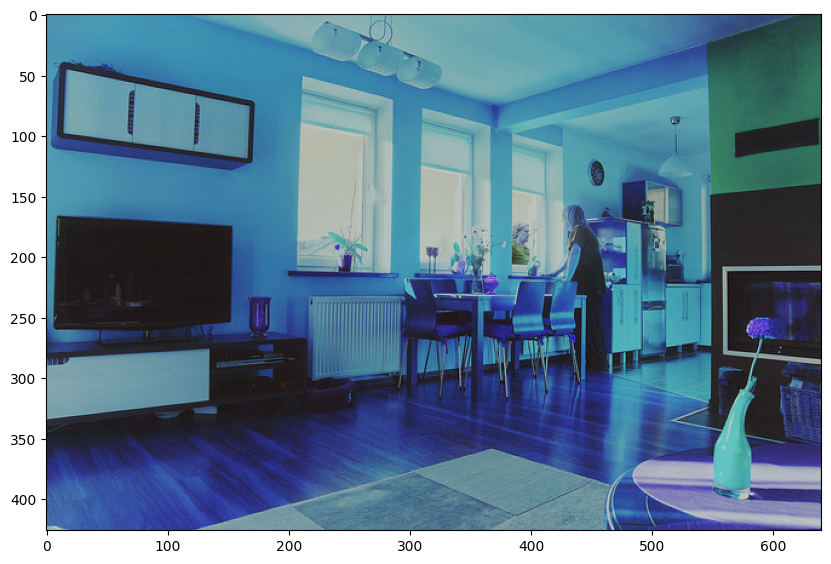

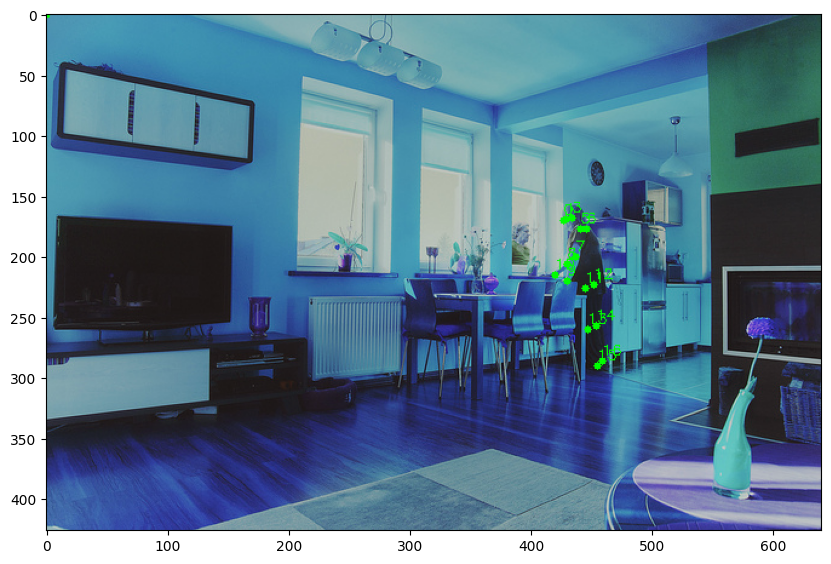

In [159]:
img_idx = 0
instance = annot_mpii_on_coco[img_idx]
# 12 - width?
img_name = ""
for i in range(12 - len(str(instance['image_id']))):
  img_name += "0"
img_name += str(instance['image_id'])
print(img_name)

image = cv2.imread(ROOT_FOLDER + '/data/COCO/original/val2017/' + f"{img_name}.jpg")

for i in range(0,len(instance['keypoints']), 3):
  kp = instance['keypoints']
  if kp[i+2] < 0.4:
    continue
  x, y = int(kp[i]), int(kp[i+1])
  cv2.circle(image, (x, y), 3, (0, 255, 0, 150), -1)
  cv2.putText(image, str(i//3), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)  # Label the index
plt.figure(figsize=(10, 10))
plt.imshow(image)

instance = annot_truth[img_idx]
image1 = cv2.imread(ROOT_FOLDER + '/data/COCO/original/val2017/' + f"{img_name}.jpg")
for i in range(0,len(instance['joints_3d'])):
  kp = instance['joints_3d']
  x, y = int(kp[i][0]), int(kp[i][1])
  cv2.circle(image1, (x, y), 3, (0, 255, 0, 150), -1)
  cv2.putText(image1, str(i), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)  # Label the index

plt.figure(figsize=(10, 10))
plt.imshow(image1)

In [107]:
lo(points_pred[:,:, :-1])

array[149813, 16, 2] n=4794016 (37Mb) x∈[-431.730, 1.188e+03] μ=236.321 σ=169.809

In [108]:
lo(points_gt[:,:,:-1])

array[149813, 17, 2] f32 n=5093642 (19Mb) x∈[0., 639.000] μ=168.873 σ=167.610

In [109]:
bbox_left = bbox[:, :-2]
bbox_wh = bbox[:, -2:]
lo(bbox_wh)

array[149813, 2] n=299626 (2.3Mb) x∈[10.710, 639.000] μ=163.920 σ=124.708

In [110]:

def normalize(data, bbox, joints_vis):
    # Ensure data type consistency
    data = data.astype(np.float32)
    bbox = bbox.astype(np.float32)
    joints_vis = joints_vis.astype(np.float32)
    
    # data [N, 17, 3]
    _data = data[:, :, :-1]
    _data_scores = data[:, :, -1]
    _joints_vis = joints_vis[:, :, :-1]

    bbox_left = bbox[:, :-2]
    bbox_wh = bbox[:, -2:]
    _data = (_data - bbox_left[:, np.newaxis]) * _joints_vis
    _data = _data / bbox_wh[:, np.newaxis]
    return np.concatenate((_data, np.expand_dims(_data_scores, axis=-1)), axis=-1, dtype=np.float32)

def unnormalize(data, bbox, joints_vis):
    # Ensure data type consistency
    data = data.astype(np.float32)
    bbox = bbox.astype(np.float32)
    joints_vis = joints_vis.astype(np.float32)
    
    # data [N, 17, 3]
    _data = data[:, :, :-1]
    _data_scores = data[:, :, -1]
    _joints_vis = joints_vis[:, :, :-1]

    bbox_left = bbox[:, :-2]
    bbox_wh = bbox[:, -2:]

    _data = _data * bbox_wh[:, np.newaxis]
    _data = _data + (bbox_left[:, np.newaxis] * _joints_vis)
    
    return np.concatenate((_data, np.expand_dims(_data_scores, axis=-1)), axis=-1, dtype=np.float32)


# Normalize data
X_normalized = normalize(points_pred, bbox, np.ones_like(points_pred))
y_normalized = normalize(points_gt, bbox, joints_vis)

# Debugging output


### Check normalize & unnormalize
- $x = f^{-1}( f(x) )$

In [112]:
identity = normalize(
      unnormalize(points_pred, bbox, np.ones_like(points_pred))
      , bbox, np.ones_like(points_pred))

# Find elements that are not equal
print("Diff: ", (identity - points_pred).sum())

identity =normalize(
      unnormalize(points_gt, bbox, joints_vis)
      , bbox, joints_vis)

print("Diff: ", (identity - points_gt).sum())


Diff:  0.0005821486083732452
Diff:  -0.0061630607


In [113]:
print(lo(X_normalized))
print(lo(y_normalized))

array[149813, 16, 3] f32 n=7191024 (27Mb) x∈[-7.625, 11.495] μ=0.519 σ=0.540
array[149813, 17, 3] f32 n=7640463 (29Mb) x∈[-7.457, 5.961] μ=0.206 σ=0.297


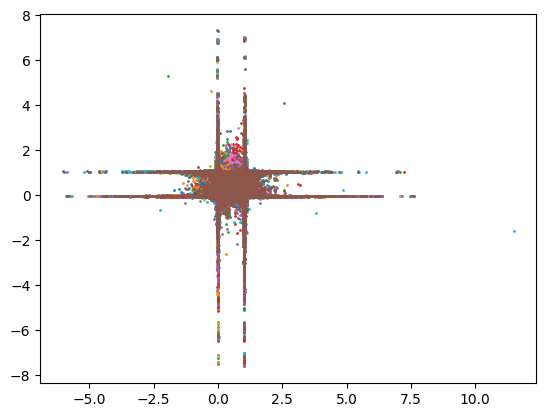

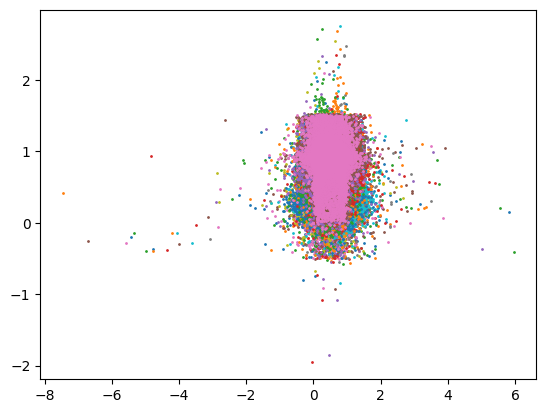

In [114]:

for i in range(16):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(17):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

## Evaluate with OKS(Object Keypoints Similarity) for AP

$$ OKS = \Sigma_{i} [exp(\frac{-d_{i}^{2}}{2s^{2}k_{i}^2}) \delta(v_{i}>0)] / \Sigma_{i} [\delta(v_{i}>0)]  $$
- where $d_{i}$ is euclidian distance for $i^{th}$ point
- where $s$ is the object scale and $k_{i}$ is a per-keypont constant that controls falloff
- where $v_{i}$ is visibility flag for $i^{th}$ keypoint

In [89]:
# Given prediction and ground truth with of Nx17x2, where N is sample num return PCKh-ish score.
def calculateAccuracy(preds, gts, joints_vis):
  """
  Will only work on normalized values
  """
  _preds = preds[:,:,:-1]
  _gts = gts[:,:,:-1]


  distance = np.linalg.norm(_preds - _gts, axis=-1)
  distance = distance * joints_vis.astype(bool).astype(int)
  total_points = joints_vis
  total_vis = total_points > 0
  total_unvis = total_points == 0
  under_threshold = distance < 0.1
  
  return (under_threshold.sum() - total_unvis.sum())  / total_vis.sum()
# Example usage
acc = calculateAccuracy(y_normalized, y_normalized, joints_vis[:,:,0])
print(acc)
# ap_score = calculate_ap(points_pred, points_gt, bbox)
# print("Average Precision (AP) score:", ap_score)

# coco_dataset._do_python_keypoint_eval("/datagrid/personal/baljibil/repos/scripts/data/from_vitpose_base_multi/IMG-coco_small-Rep-coco.json")



    
  

1.0


## Baseline

In [90]:
def handcraft(mpii_x, coco_y):
  """
  Connecting mergeable points to the correct index
  """
  mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}
  # Mergeable points merge
  X_coco = np.ones_like(coco_y)
  # Merge-able points
  for mpii_key, coco_key in mapping.items():
    X_coco[:,coco_key] = mpii_x[:,mpii_key]
  # pelvis (To define baseline, pelvis is almost in the middle of left and right hip)
  X_coco[:, 0] = (mpii_x[:,8] + mpii_x[:,9])/2
  return X_coco

X_transformed_normalized = handcraft(X_normalized, y_normalized)
print(calculateAccuracy(X_transformed_normalized, y_normalized, joints_vis[:,:,0]))

0.563151417873777


In [ ]:
# import json
# res_file = 'results/res.json'

# rec = []
# X_transformed_unnormalized = unnormalize(X_transformed_normalized, bbox, np.ones_like(X_transformed_normalized))
# X_transformed_unnormalized[:,:,2] = 1
# res_points = X_transformed_unnormalized.reshape(X_transformed_unnormalized.shape[0], 51)
# for i in range(len(annot_mpii_on_coco)):
#   keypoints = res_points[i].astype(int).tolist()
#   rec.append({"image_id": annot_mpii_on_coco[i]['image_id'], 
#               "category_id": annot_mpii_on_coco[i]['category_id'], 
#               "keypoints": keypoints, 
#               "score": 0.5,})
# # X_transformed_normalized

# with open(res_file, 'w') as f:
#   json.dump(rec, f, indent=4)

# print(X_transformed_unnormalized[0])

[[364.38495 471.7096    1.     ]
 [477.19    627.08      1.     ]
 [477.19    627.08      1.     ]
 [477.19    627.08      1.     ]
 [477.19    627.08      1.     ]
 [365.54926 335.8472    1.     ]
 [403.20697 488.51154   1.     ]
 [404.08606 491.70184   1.     ]
 [367.0846  337.60532   1.     ]
 [444.4273  620.79456   1.     ]
 [243.1992  455.6546    1.     ]
 [360.42584 610.67944   1.     ]
 [261.63257 611.7035    1.     ]
 [261.6983  612.84595   1.     ]
 [357.7107  612.19226   1.     ]
 [311.77533 611.3645    1.     ]
 [357.2224  627.2311    1.     ]]


In [ ]:
# coco_dataset._do_python_keypoint_eval("/datagrid/personal/baljibil/repos/scripts/results/res.json")


Loading and preparing results...
DONE (t=5.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=76.01s).
Accumulating evaluation results...
DONE (t=2.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.086
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.072
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.268
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

[('AP', 0.014333578294363259),
 ('AP .5', 0.08601865398734994),
 ('AP .75', 0.0017241221915283175),
 ('AP (M)', 0.02176688820526306),
 ('AP (L)', 0.010283782181589382),
 ('AR', 0.071726752685014),
 ('AR .5', 0.2681809989787268),
 ('AR .75', 0.030224346351785225),
 ('AR (M)', 0.07212861356932153),
 ('AR (L)', 0.07130166146657856)]

In [104]:
annot_mpii_on_coco[0]

{'category_id': 1,
 'center': [322.385009765625, 394.9849853515625],
 'image_id': 36,
 'keypoints': [490.689697265625,
  141.91949462890625,
  0.7978225350379944,
  487.56719970703125,
  139.56594848632812,
  0.7982988357543945,
  263.339111328125,
  596.6326904296875,
  0.724897563457489,
  354.42181396484375,
  593.6689453125,
  0.8542584180831909,
  487.59063720703125,
  141.11175537109375,
  0.8247277140617371,
  495.49578857421875,
  144.34686279296875,
  0.7636021971702576,
  309.8702392578125,
  593.069580078125,
  0.7930697202682495,
  489.6663818359375,
  140.84893798828125,
  1.1136213541030884,
  489.52447509765625,
  142.9931640625,
  1.1032137870788574,
  493.24517822265625,
  143.70907592773438,
  0.8517482876777649,
  243.3003692626953,
  450.5614929199219,
  0.8905096054077148,
  212.6197967529297,
  516.221923828125,
  0.9202196598052979,
  204.15635681152344,
  340.6265563964844,
  0.9126896858215332,
  364.00201416015625,
  335.2832336425781,
  0.9798396229743958,
  

In [115]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

# gt [N 17 3]
# but we need to pass the bounding boxes for each object as well
gt_y = y_normalized
gt_y[:,:,2] = joints_vis[:,:,0]

X_tiny = X_normalized[:20000]
y_tiny = gt_y[:20000]

X_train, X_val, y_train, y_val = train_test_split(X_tiny, y_tiny, test_size=0.2, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64)


Train instance:  16000
Val instance:  4000
torch.Size([16000, 16, 3])
torch.Size([16000, 17, 3])
torch.Size([4000, 16, 3])
torch.Size([4000, 17, 3])


In [140]:
def display_learning_image(net, img_path, x_keypoints, y_keypoints, bbox, save_path='results/training/'):
    X = normalize(x_keypoints, bbox, np.ones_like(x_keypoints))
    X = X[:, :-1]
    X = torch.tensor(X).to(device)
    output = net(X).detach().cpu().numpy()
    output = np.concatenate((output, torch.ones((1, 17, 1))), axis=-1)
    preds = unnormalize(output, bbox, np.ones_like(output))
    
    image = cv2.imread(img_path)
    image1 = image.copy()
    image2 = image.copy()

    # Unbatch size
    original_x = x_keypoints[0]
    for kp in original_x:
        x, y = int(kp[0]), int(kp[1])
        # Red
        cv2.circle(image, (x, y), 3, (0, 0, 255), -1)
    
    normalize_x = normalize(x_keypoints, bbox, np.ones_like(x_keypoints))
    unnormalize_x = unnormalize(normalize_x, bbox, np.ones_like(normalize_x))
    
    for kp in unnormalize_x[0]:
        x, y = int(kp[0]), int(kp[1])
        # Green
        cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

    preds = preds[0]
    for kp in preds:
        x, y = int(kp[0]), int(kp[1])
        cv2.circle(image1, (x, y), 3, (0, 255, 0), -1)

    # Unbatch size
    y_keypoints = y_keypoints[0]
    for kp in y_keypoints:
        x, y = int(kp[0]), int(kp[1])
        cv2.circle(image2, (x, y), 3, (0, 255, 0), -1)

    # Adding labels
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    color = (255, 255, 255)  # White color
    (text_width, text_height), baseline = cv2.getTextSize('X', font, font_scale, thickness)
    
    cv2.putText(image, 'X', (10, text_height + 10), font, font_scale, color, thickness)
    cv2.putText(image1, 'Prediction', (10, text_height + 10), font, font_scale, color, thickness)
    cv2.putText(image2, 'GT', (10, text_height + 10), font, font_scale, color, thickness)

    combined_image = np.concatenate((image, image1, image2), axis=1)
    cv2.imwrite(f'{save_path}.jpg', combined_image)
    print(f"wrote image to {save_path}.jpg")

img_index = 0



In [141]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self):
        super().__init__()
 
        self.layers = nn.Sequential(nn.Flatten(),
                                     nn.Linear(2*16,512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 512),
                                     nn.Tanh(),
                                     nn.Linear(512, 2*17)
                                     )
    def forward(self, x):
        x = self.layers(x)
        return x.view(-1, 17, 2)

def init_model():
    return TranslatorNN().to(device)

In [138]:
def train_model(model, lr=0.01, max_epoch=100, logs=[]):
    criterion = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    best_epoch = 0
    best_val_loss = 10000000
    best_model = None
    best_accuracy = 0
    # Training loop
    for epoch in range(max_epoch):
        if epoch == 0:
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    joints_vis = targets[:,:,-1].unsqueeze(-1)
                    print(joints_vis)
                    outputs = model(inputs[:,:,:-1])
                    loss = criterion(outputs * joints_vis, targets[:,:,:-1] * joints_vis)
                    val_loss += loss.item() * inputs.size(0)
            val_epoch_loss = val_loss / len(val_dataset)
        
            print(f"Epoch [{epoch}/{max_epoch}], Val Loss: {val_epoch_loss:.6f}")
        model.train()
        running_loss = 0.0
        train_accuracy = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            joints_vis = targets[:,:,-1].unsqueeze(-1)
            optimizer.zero_grad()
            outputs = model(inputs[:,:,:-1])
            loss = criterion(outputs * joints_vis, targets[:,:,:-1] * joints_vis)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            with torch.no_grad():
                train_accuracy += (calculateAccuracy(outputs.detach().cpu().numpy(), 
                                                     targets.detach().cpu().numpy(),
                                                     targets[:,:,-1].detach().cpu().numpy()))

        epoch_loss = running_loss / len(train_dataset)
        train_accuracy = train_accuracy / (len(train_dataset) / train_loader.batch_size)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_size = 0
        accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                joints_vis = targets[:,:,-1].unsqueeze(-1)


                outputs = model(inputs[:,:,:-1])
                loss = criterion(outputs * joints_vis, targets[:,:,:-1] * joints_vis)
                val_loss += loss.item() * inputs.size(0)
                val_size += inputs.size(0)
                with torch.no_grad():
                    accuracy += (calculateAccuracy(outputs.detach().cpu().numpy(), 
                                                     targets.detach().cpu().numpy(),
                                                     targets[:,:,-1].detach().cpu().numpy()))

        val_epoch_loss = val_loss / len(val_dataset)
        # Cuz batch size is 1?
        accuracy = accuracy / (len(val_dataset) / val_loader.batch_size)
        # For 16 keypoints
        if accuracy > best_accuracy:
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_val_loss = val_loss
            best_accuracy = accuracy
        logs.append((epoch+1,epoch_loss, val_epoch_loss, accuracy))
        if (epoch+1) % 10 == 1:
            print(f"Epoch [{epoch+1}/{max_epoch}], Train Loss: {epoch_loss:.6f}, TAccuracy: {train_accuracy * 100:.2f}%,  Val Loss: {val_epoch_loss:.6f} Accuracy: {accuracy * 100:.2f}%")
        if (epoch+1) % 20 == 1:
            img_index = 0
            display_learning_image(model,
                                   annot_truth[img_index]['image_file'],
                                   np.expand_dims(np.array(annot_mpii_on_coco[img_index]['keypoints']).reshape(16,3), axis=0),
                                   np.expand_dims(annot_truth[img_index]['joints_3d'], axis=0),
                                   np.expand_dims(bbox[img_index],axis=0),
                                   f'results/training/image{img_index}-{epoch}'
                                   )
    # model at best epoch
    return best_epoch, best_model, best_val_loss, best_accuracy



In [142]:
# learning_rates = [1, 0.1, 0.15, 0.5, 0.01, 0.03, 0.001, 0.003, 0.0001]
learning_rates = [3e-4]

# batch_size = [1,4,8,16,32,64]
epoch_max = [200]
param_comb = [{'lr':x, 'epoch':y} for x in learning_rates for y in epoch_max]
print(len(param_comb),param_comb)

best_model = None
best_loss = None
best_params = None
best_accuracy = 0
best_model_logs = []
torch.manual_seed(42)
for param in param_comb:
  print(f'Training for param: {param}')
  lr = param['lr']
  epoch = param['epoch']
  results_logs = []
  model = init_model()
  print(model)
  t_epoch, t_model, t_loss, t_accuracy = train_model(model,lr=lr,max_epoch=epoch,logs=results_logs)
  print(f'{param} -> {t_accuracy:.4f}')

  if t_accuracy > best_accuracy:
    best_model = copy.deepcopy(t_model)
    best_model_logs = copy.deepcopy(results_logs)
    best_loss = t_loss
    best_epoch = t_epoch
    best_params = param
    best_accuracy = t_accuracy
  



1 [{'lr': 0.0003, 'epoch': 200}]
Training for param: {'lr': 0.0003, 'epoch': 200}
TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Tanh()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Tanh()
    (9): Linear(in_features=512, out_features=34, bias=True)
  )
)
tensor[64, 17, 1] n=1088 (4.2Kb) x∈[0., 1.000] μ=0.633 σ=0.482 cuda:3
tensor[64, 17, 1] n=1088 (4.2Kb) x∈[0., 1.000] μ=0.597 σ=0.491 cuda:3
tensor[64, 17, 1] n=1088 (4.2Kb) x∈[0., 1.000] μ=0.628 σ=0.484 cuda:3
tensor[64, 17, 1] n=1088 (4.2Kb) x∈[0., 1.000] μ=0.664 σ=0.473 cuda:3
tensor[64, 17, 1] n=1088 (4.2Kb) x∈[0., 1.000] μ=0.662 σ=0.473 cuda:3
tensor[64, 17, 1] n=1088 (4.2Kb) x∈[0., 1.000] μ=0.664 σ=0.473 cuda:3
tensor[64, 17, 1] n=1088 (4.2Kb) x∈[0., 

In [ ]:
# TODO:
# - implement OKS
# - understand the score for each points. Feed in only quality points
# - start use joint_visibilities. Don't calculate loss for points that are not visible ofc

### Do the API EVAL

In [89]:
import json



def evalCOCO(coco_dataset, pred, annot_mpii_on_coco, file_path):
  res_file = file_path

  rec = []
  pred[:,:,2] = 1
  res_points = pred.reshape(pred.shape[0], 51)
  for i in range(len(coco_dataset.db)):
    keypoints = res_points[i].astype(int).tolist()
    rec.append({"image_id": annot_mpii_on_coco[i]['image_id'], 
                "category_id": annot_mpii_on_coco[i]['category_id'], 
                "keypoints": keypoints, 
                "score": 1,})
  # X_transformed_normalized

  with open(res_file, 'w') as f:
    json.dump(rec, f, indent=4)
  coco_dataset._do_python_keypoint_eval("/datagrid/personal/baljibil/repos/scripts/results/res.json")

best_model.eval()

with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_base_multi/IMG-coco_small-Rep-mpii.json') as f:
    annot_mpii_on_coco_val = json.load(f)

annot_mpii_on_coco_val = sorted(annot_mpii_on_coco_val, key=lambda x: int(x['image_id']))

points_pred = [item['keypoints'] for item in annot_mpii_on_coco]
points_pred = np.array(points_pred)
points_pred = points_pred.reshape(points_pred.shape[0], 17, 3)

joints_vis = [item['joints_3d_visible'] for item in annot_truth]
bbox = [item['bbox'] for item in annot_truth]

joints_vis = np.array(joints_vis)
bbox = np.array(bbox)

input = normalize(points_pred, bbox, np.ones_like(points_pred))
input = torch.tensor(X_normalized[:,:,:-1]).to(device)
preds = best_model(input)
preds = preds.detach().cpu()
preds = torch.cat((preds,torch.ones((preds.size(0), preds.size(1), 1))), dim=-1)
preds = unnormalize(preds.numpy(), bbox, np.ones_like(preds))
evalCOCO(coco_dataset,preds,annot_mpii_on_coco, "results/res.json")

Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=3.31s).
Accumulating evaluation results...
DONE (t=0.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.034
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.149
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.112
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.354
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

In [71]:
best_model


TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Tanh()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Tanh()
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Tanh()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): Tanh()
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): Tanh()
    (13): Linear(in_features=512, out_features=34, bias=True)
  )
)